In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
#下一行可以让数据集在单元格中嵌入化显示
%matplotlib inline

In [82]:
#读取数据
dataset_test = pd.read_csv('data/testdata.csv')
dataset_train = pd.read_csv('data/traindata.csv')

In [83]:
#先分开取出训练集的男女数据
dataset_male_train = dataset_train[dataset_train['gender'] == 'Male']
dataset_female_train = dataset_train[dataset_train['gender'] == 'Female']

#分别提取男女的身高体重特征
body_male_train = dataset_male_train[['height','weight']]
body_female_train = dataset_female_train[['height','weight']]
body_male_train.head()

,height,weight
0,175.0,65.0
1,172.0,64.3
2,176.0,63.0
3,175.0,60.0
4,160.0,75.0


In [84]:
#最大似然估计
male_data = body_male_train.describe()
female_data = body_female_train.describe()

male_result = {}
male_result['height_mean'] = body_male_train['height'].mean()
male_result['height_sig'] = body_male_train['height'].std()
male_result['weight_mean'] = body_male_train['weight'].mean()
male_result['weight_sig'] = body_male_train['weight'].std()

female_result = {}
female_result['height_mean'] = body_female_train['height'].mean()
female_result['height_sig'] = body_female_train['height'].std()
female_result['weight_mean'] = body_female_train['weight'].mean()
female_result['weight_sig'] = body_female_train['weight'].std()

print('男生参数:\n\t\t身高\t\t\t体重\n平均值\t{}\t{}\n标准差\t{}\t{}\n'. 
      format(male_result['height_mean'], male_result['weight_mean'], 
             male_result['height_sig'], male_result['weight_sig']))
print('女生参数:\n\t\t身高\t\t\t体重\n平均值\t\t{}\t\t\t{}\n标准差\t{}\t{}'. 
      format(female_result['height_mean'], female_result['weight_mean'], 
             female_result['height_sig'], female_result['weight_sig']))

男生参数:
		身高			体重
平均值	174.13400000000001	66.60799999999999
标准差	4.573196533127813	8.485662337503328

女生参数:
		身高			体重
平均值		161.03			51.956
标准差	4.479169474765771	5.457261030882037


In [85]:
#贝叶斯估计
mean0 = 0
sig0 = 1
count = {}
count['Total'] = dataset_train.shape[0]
count['Male'] = dataset_male_train.shape[0]
count['Female'] = dataset_female_train.shape[0]


male_result['height_mean_bayes'] = (1/(count['Male']+male_result['height_sig']**2))*(body_male_train['height'].sum())
male_result['weight_mean_bayes'] = (1/(count['Male']+male_result['weight_sig']**2))*(body_male_train['weight'].sum())

female_result['height_mean_bayes'] = (1/(count['Female']+female_result['height_sig']**2))*(body_female_train['height'].sum())
female_result['weight_mean_bayes'] = (1/(count['Female']+female_result['weight_sig']**2))*(body_female_train['weight'].sum())

print('男生参数:\n\t\t身高\t\t\t体重\n均值\t{}\t{}\n'.
      format(male_result['height_mean_bayes'], male_result['weight_mean_bayes']))
print('女生参数:\n\t\t身高\t\t\t体重\n均值\t{}\t{}\n'.
      format(female_result['height_mean_bayes'], female_result['weight_mean_bayes']))

男生参数:
		身高			体重
均值	122.7780757652213	27.296914074543523

女生参数:
		身高			体重
均值	114.91806931666416	32.56135262161298



决策面

In [86]:
#先验概率
P_male = count['Male']/count['Total']
P_female = 1-P_male

In [87]:
#协方差矩阵
male_array = np.array(body_male_train)
female_array = np.array(body_female_train)
sig_male = np.cov(male_array.T)
sig_female = np.cov(female_array.T)


sig_female[0][1] = 0
sig_female[1][0] = 0
sig_male[0][1] = 0
sig_male[1][0] = 0


In [88]:
#均值
mean_male = np.array([male_result['height_mean'], male_result['weight_mean']]).reshape(-1, 1)
mean_female = np.array([female_result['height_mean'], female_result['weight_mean']]).reshape(-1, 1)

In [89]:
#用来预测性别，vlue>0为女，<0为男
#point:         要预测的点
#mean_male      男性的均值矩阵
#mean_female    女性的均值矩阵
#sig_male       男性的方差与协方差矩阵
#sig_female     女性的方差与协方差矩阵
#P_male         男性先验概率
#P_female       女性先验概率
def Predict_sex(point, mean_male, mean_female, sig_male, sig_female, P_male, P_female):
    value = 0.5 * (np.dot(np.dot((point-mean_male).T,np.linalg.inv(sig_male)), (point-mean_male))[0][0] -\
        np.dot(np.dot((point-mean_female).T,np.linalg.inv(sig_female)), (point-mean_female))[0][0]) +\
        0.5 * math.log(np.linalg.det(sig_female)/np.linalg.det(sig_male)) - math.log(P_male/P_female) 
    return value

身高为180,体重120, 预测性别为:男


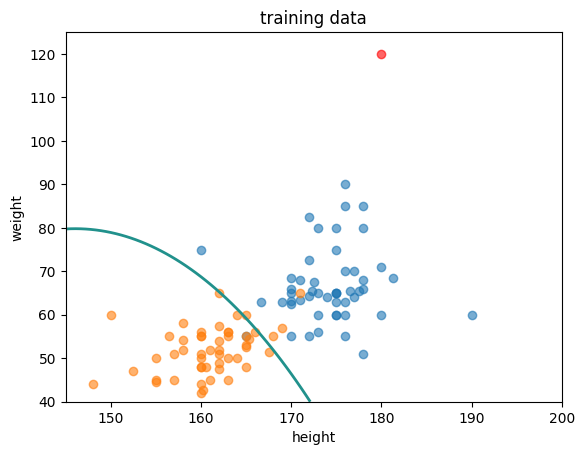

In [90]:
#划分决策面
sample_height = np.linspace(145, 200, 100)
sample_weight = np.linspace(40, 125, 100)
sample = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        x = np.array([sample_height[i], sample_weight[j]]).reshape(-1,1)
        '''x例子[[145.]
                 [ 40.]]'''
        sample[i,j] = Predict_sex(x, mean_male, mean_female, sig_male, sig_female, P_male, P_female)

plt.scatter(body_male_train[['height']], body_male_train[['weight']], alpha=0.6)
plt.scatter(body_female_train[['height']], body_female_train[['weight']], alpha=0.6)
plt.xlabel('height')
plt.ylabel('weight')
plt.title('training data')
plt.contour(sample_height, sample_weight, sample, 0, linewidths=2)

#身高为180,体重120的性别
point0 = ([[180],[120]])
plt.scatter(point0[0], point0[1], alpha=0.6, color='red')
sex_point0 = Predict_sex(point0, mean_male, mean_female, sig_male, sig_female, P_male, P_female)
if sex_point0>0:
    print('身高为180,体重120, 预测性别为:女')
else:
    print('身高为180,体重120, 预测性别为:男')

plt.show()


开始预测测试集，查看准确率

In [91]:
#取出测试集测试准确率
body_test = dataset_test[['height','weight']]
sex_test = dataset_test[['gender']]
body_test.head()

,height,weight
0,180,72.0
1,169,68.0
2,181,72.0
3,175,61.0
4,172,55.0


In [92]:
predict_result = []
#获取测试集的预测结果
for point in body_test.values:
    x = np.array(point).reshape(-1,1)
    if Predict_sex(x, mean_male, mean_female, sig_male, sig_female, P_male, P_female) > 0:
        predict_result.append(['Female'])
    else:
        predict_result.append(['Male'])

In [93]:
# 分析比较预测的结果
count_predic_correct = 0
count_predic_wrong = 0
sex_array = sex_test.values

for i in range(len(sex_array)):
    if predict_result[i][0] == sex_array[i][0]:
        count_predic_correct += 1
    else:
        count_predic_wrong += 1
        
accuracy = count_predic_correct/(count_predic_correct + count_predic_wrong)*100
print('经过测试集的测试，预测的准确率为：%.2f'% accuracy, '%')

经过测试集的测试，预测的准确率为：89.00 %
